# GANdy: A Study on GANs, and how fully connected layers affect them

GANs are a mistery, let's get some conclussions...

In [110]:
import torch
import torchvision
from torch import nn, optim
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

## Dataset
Let's first load our dataset, for the purpose of this study I'll use FashionMNIST

In [46]:
dataset = FashionMNIST('dataset', train=True, transform=torchvision.transforms.ToTensor(),download=True)
dataloader = DataLoader(dataset, shuffle=True, batch_size=64)

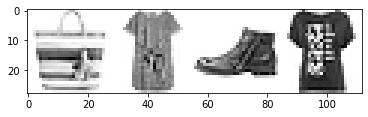

In [47]:
# Let's visualize some data
images, _ = next(iter(dataloader))

plt.imshow(torch.cat([img[0] for img in images[:4]], dim=-1), cmap='Greys')
plt.show()

# Our Tools
Let´s now define the tools that we're going to use for this exercice, for instance: 
- the models
- the training schedule

In [48]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        try:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        except AttributeError:
            print("Skipping initialization of ", classname)
    elif classname.find('BatchNorm2d') != -1:
        try:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
            nn.init.constant_(m.bias.data, 0.0)
        except AttributeError:
            print("Skipping initialization of ", classname)

In [90]:
# Simple GAN
class SimpleGenerator(nn.Module):
    def __init__(self, noise_size=7*7, hidden_size=128):
        super(SimpleGenerator, self).__init__()
        
        self.hidden_size = hidden_size
        self.reshaper = nn.Linear(noise_size, 7*7*hidden_size)
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(hidden_size, hidden_size//2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_size//2),
            nn.ReLU(),
            
            nn.ConvTranspose2d(hidden_size//2, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        
        self.apply(weights_init_normal)
        
    def forward(self, x):
        x = self.reshaper(x).view(-1, self.hidden_size, 7, 7)
        x = self.generator(x)
        return x
    
class PreshapedGenerator(nn.Module):
    def __init__(self, noise_size=7*7, hidden_size=128):
        super(PreshapedGenerator, self).__init__()
        
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(1, hidden_size, kernel_size=3, padding=1, bias=False), # dimension expand
            
            nn.ConvTranspose2d(hidden_size, hidden_size//2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_size//2),
            nn.ReLU(),
            
            nn.ConvTranspose2d(hidden_size//2, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        
        self.apply(weights_init_normal)
        
    def forward(self, x):
        x = self.generator(x)
        return x
    
class SimpleDiscriminator(nn.Module):
    def __init__(self, hidden_size=32):
        super(SimpleDiscriminator, self).__init__()
        
        self.discriminator = nn.Sequential(           
            nn.Conv2d(1, hidden_size//2, kernel_size=4, stride=2, padding=1, bias=False), # 14 > 7
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(hidden_size//2, hidden_size, kernel_size=4, stride=2, padding=1, bias=False), # 7 > 3
            nn.BatchNorm2d(hidden_size),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(hidden_size, 1, kernel_size=1, bias=False)
        )
        
        self.pooling = nn.AdaptiveAvgPool2d((1, 1))
        
    def forward(self, x):
        x = self.discriminator(x)
        x = self.pooling(x).view(-1)       
        return x


torch.Size([3, 1, 28, 28]) torch.Size([3])


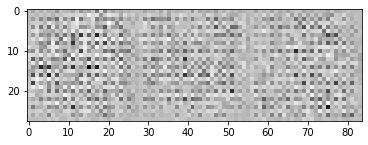

In [91]:
simpleGenerator = PreshapedGenerator()
simpleDiscriminator = SimpleDiscriminator()
simpleGenerator.cuda(), simpleDiscriminator.cuda()
print("")

with torch.no_grad():
    gen = simpleGenerator(torch.randn(3, 1, 7, 7).cuda())
    disc = simpleDiscriminator(gen)
    print(gen.shape, disc.shape)
    plt.imshow(torch.cat([img[0] * 0.5 + 0.5 for img in gen.cpu()], dim=-1), cmap='Greys')
    plt.show()

In [81]:
def train(generator, discriminator, noise_generator, epochs=30):
    fixed_noise = noise_generator(3).cuda()
    losses_g = []
    losses_d = []    
    criterion = nn.BCEWithLogitsLoss()
    optimizer_g = optim.Adam(generator.parameters(), lr=0.0002)
    optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002)
    
    for e in range(1, epochs+1):
        total_d_loss = 0
        total_g_loss = 0
        generator.train(), discriminator.train()
        for images, _ in dataloader:
            images = images.cuda() * 2 - 1
            
            noise = noise_generator(dataloader.batch_size).cuda()
            
            # first train the discriminator
            d_real = discriminator(images)
            d_real_loss = criterion(d_real, torch.ones_like(d_real))
            
            d_fake = discriminator(generator(noise).detach())
            d_fake_loss = criterion(d_fake, torch.zeros_like(d_fake))
            
            d_loss = d_real_loss + d_fake_loss
            
            total_d_loss += d_loss.item() / len(dataloader)
            
            optimizer_d.zero_grad()
            d_loss.backward()
            optimizer_d.step()
            
            # now train the generator
            d_gen = discriminator(generator(noise))
            g_loss = criterion(d_gen, torch.ones_like(d_gen))
            
            total_g_loss += g_loss.item() / len(dataloader)
            
            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()
            
        print(f"EPOCH {e}/{epochs} - d_loss {total_d_loss} - g_loss {total_g_loss}")
        losses_g.append(total_g_loss)
        losses_d.append(total_d_loss)
        generator.eval(), discriminator.eval()
        with torch.no_grad():
            gen = generator(fixed_noise)
            plt.imshow(torch.cat([img[0] * 0.5 + 0.5 for img in gen.cpu()], dim=-1), cmap='Greys')
            plt.show()
            
    plt.plot(losses_g, label="G")
    plt.plot(losses_d, label="D")
    plt.legend()
    plt.show()

# Experiments

Now let´s train all the variations of the simple GANs that we created to get some conclusions

### Simple DCGAN with a FC as first layer of the generator

EPOCH 1/10 - d_loss 1.2569533933454484 - g_loss 0.7019767031740792


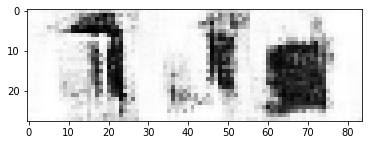

EPOCH 2/10 - d_loss 1.3008404682948396 - g_loss 0.7322975129588074


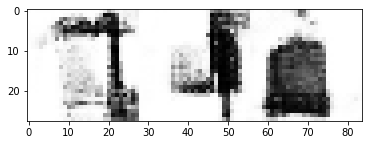

EPOCH 3/10 - d_loss 1.2969331656183516 - g_loss 0.744261821005136


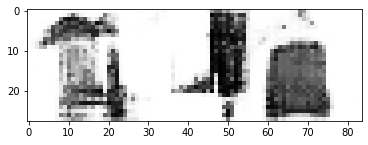

EPOCH 4/10 - d_loss 1.2804609689631188 - g_loss 0.7588507323376912


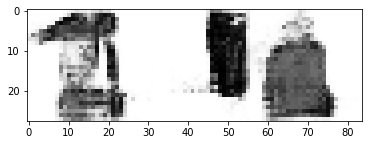

EPOCH 5/10 - d_loss 1.2665299926993703 - g_loss 0.7711773839459499


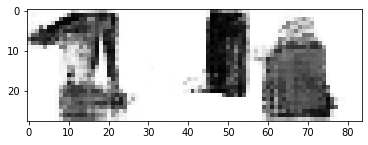

EPOCH 6/10 - d_loss 1.2613264138002114 - g_loss 0.7766215174055807


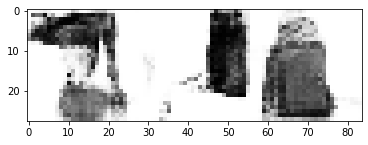

EPOCH 7/10 - d_loss 1.2472751844666417 - g_loss 0.7836983107300445


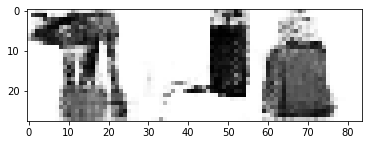

EPOCH 8/10 - d_loss 1.2372154791726242 - g_loss 0.7918315029093456


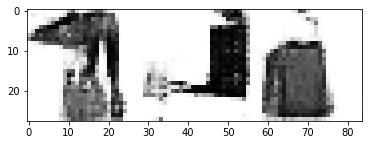

EPOCH 9/10 - d_loss 1.2322652285287141 - g_loss 0.798174627363556


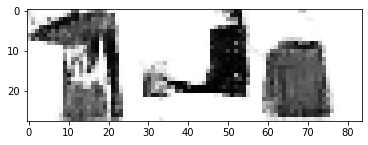

EPOCH 10/10 - d_loss 1.232205953425184 - g_loss 0.8012370826847283


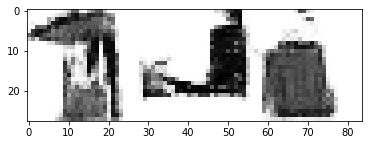

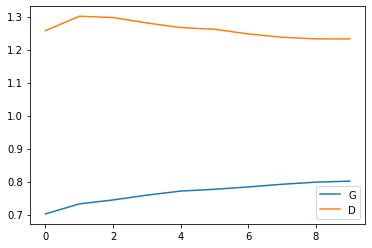

In [82]:
simpleGenerator = SimpleGenerator()
simpleDiscriminator = SimpleDiscriminator()
simpleGenerator.cuda(), simpleDiscriminator.cuda()

def gen_simple_noise(batch_size):
    return torch.randn(batch_size, 7*7)

train(simpleGenerator, simpleDiscriminator, gen_simple_noise, epochs=10)

### Simple DCGAN without a FC as first layer of the generator, so it gets the noise already shaped as an image

EPOCH 1/10 - d_loss 1.1510450240137238 - g_loss 0.7538070399115587


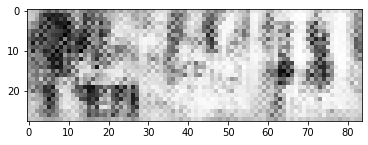

EPOCH 2/10 - d_loss 1.0942385457217827 - g_loss 0.8568409779814004


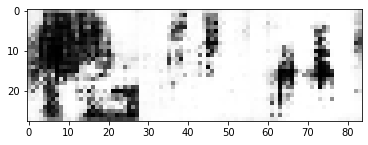

EPOCH 3/10 - d_loss 0.9751611255379369 - g_loss 0.9674678816597098


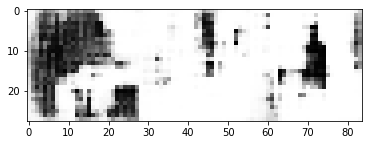

EPOCH 4/10 - d_loss 0.8652735945385395 - g_loss 1.0737013338979629


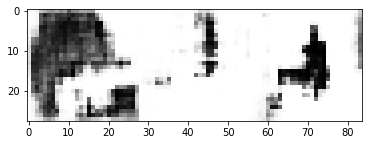

EPOCH 5/10 - d_loss 0.7604873282060441 - g_loss 1.2022121664303438


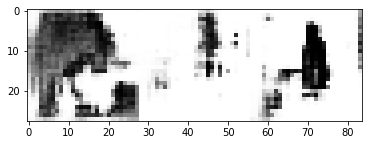

EPOCH 6/10 - d_loss 0.6541694050658734 - g_loss 1.364913090841093


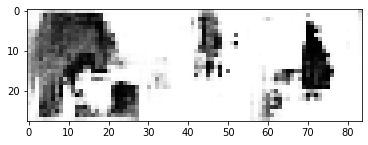

EPOCH 7/10 - d_loss 0.556568803309377 - g_loss 1.5345575458713685


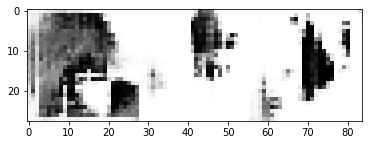

EPOCH 8/10 - d_loss 0.4855570306719489 - g_loss 1.685485682762001


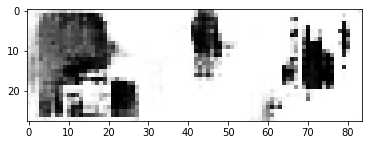

EPOCH 9/10 - d_loss 0.4299923836358827 - g_loss 1.8317950847052322


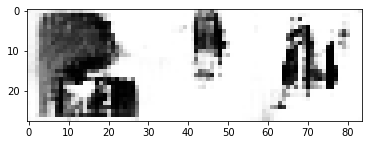

EPOCH 10/10 - d_loss 0.377693997676184 - g_loss 1.9871574017538933


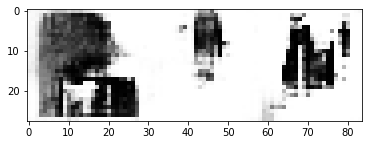

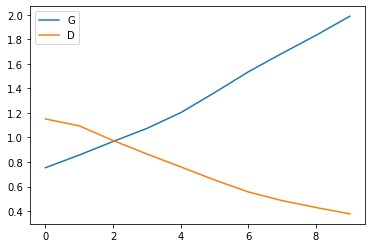

In [92]:
preshapedGenerator = PreshapedGenerator()
simpleDiscriminator = SimpleDiscriminator()
preshapedGenerator.cuda(), simpleDiscriminator.cuda()

def gen_preshaped_noise(batch_size):
    return torch.randn(batch_size, 1, 7, 7)

train(preshapedGenerator, simpleDiscriminator, gen_preshaped_noise, epochs=10)

## Intuition n1: 
Allowing the model to reshape the input noise with a Fully Connected layer helps it generate realistic samples, otherwise the model is stuck with noisy distributions for the whole process

### Conditioning
Let´s try the same thing, but now instead of random noise, we'll use a fixed noise as input, first with a realistic conditioning, then with just a matrix filled with the same value

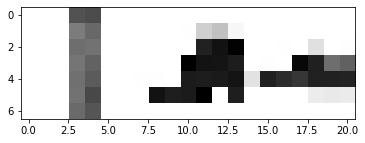

In [106]:
condition, _ = next(iter(dataloader))
condition = condition * 2 - 1 
condition = nn.functional.interpolate(condition, size=(7, 7))

plt.imshow(torch.cat([img[0] * 0.5 + 0.5 for img in condition[:3]], dim=-1), cmap='Greys')
plt.show()

EPOCH 1/10 - d_loss 1.3472297178911012 - g_loss 0.6848728360016472


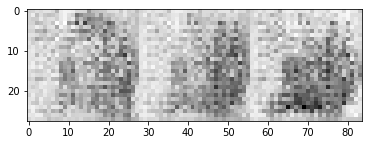

EPOCH 2/10 - d_loss 1.3476291847889865 - g_loss 0.7091595815188844


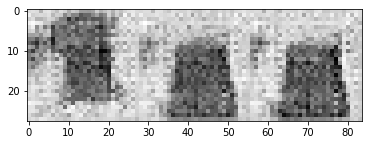

EPOCH 3/10 - d_loss 1.3565629997741429 - g_loss 0.7104588609133188


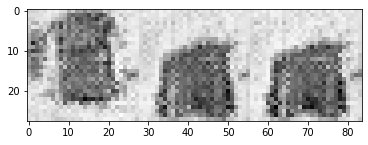

EPOCH 4/10 - d_loss 1.353836368650262 - g_loss 0.713622623097414


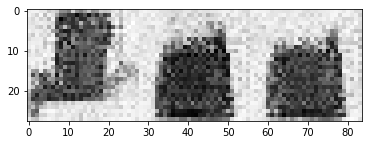

EPOCH 5/10 - d_loss 1.3412162843289406 - g_loss 0.7216907194428357


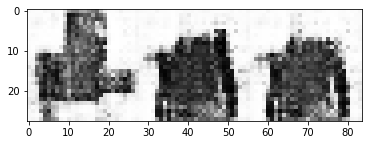

EPOCH 6/10 - d_loss 1.336928590401401 - g_loss 0.7250174673508483


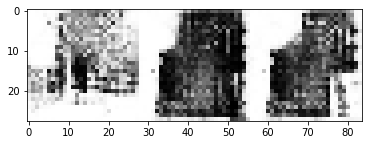

EPOCH 7/10 - d_loss 1.3570484112320653 - g_loss 0.7128080277046418


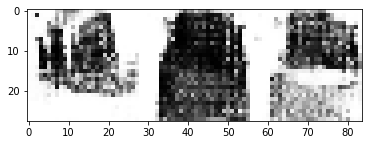

EPOCH 8/10 - d_loss 1.3852309887088945 - g_loss 0.6989015056761602


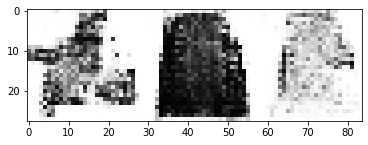

EPOCH 9/10 - d_loss 1.4106664723678939 - g_loss 0.6838222185431767


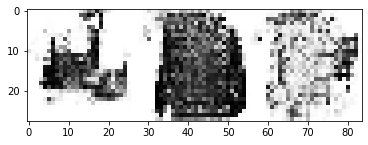

EPOCH 10/10 - d_loss 1.4078824898835702 - g_loss 0.6855768667482366


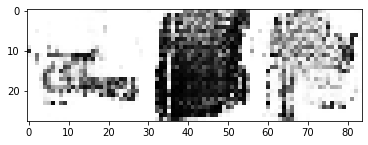

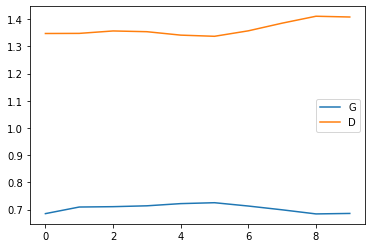

In [107]:
simpleGenerator = SimpleGenerator()
simpleDiscriminator = SimpleDiscriminator()
simpleGenerator.cuda(), simpleDiscriminator.cuda()

def gen_simple_condition(batch_size):
    return condition[:batch_size].view(batch_size, -1)

train(simpleGenerator, simpleDiscriminator, gen_simple_condition, epochs=10)

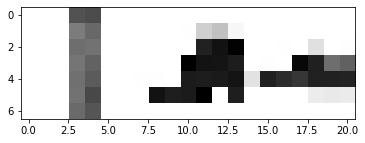

In [108]:
plt.imshow(torch.cat([img[0] * 0.5 + 0.5 for img in condition[:3]], dim=-1), cmap='Greys')
plt.show()

EPOCH 1/10 - d_loss 1.2853207628864216 - g_loss 0.7104421081954739


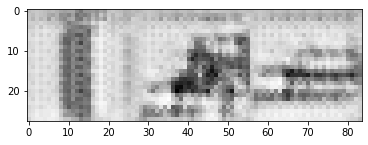

EPOCH 2/10 - d_loss 1.1436465292342954 - g_loss 0.836288137603671


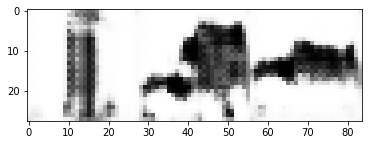

EPOCH 3/10 - d_loss 1.0685131890433175 - g_loss 0.8978477787615644


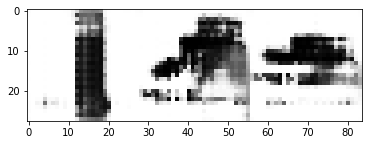

EPOCH 4/10 - d_loss 0.9706429911574818 - g_loss 0.9847506616415512


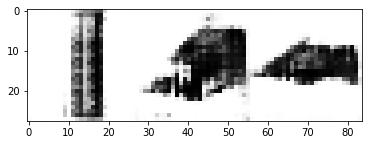

EPOCH 5/10 - d_loss 0.947176248407058 - g_loss 1.0136620955172382


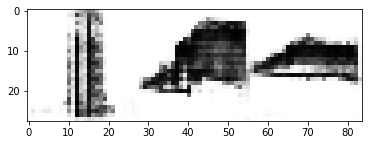

EPOCH 6/10 - d_loss 0.9200513595457015 - g_loss 1.0405501570147504


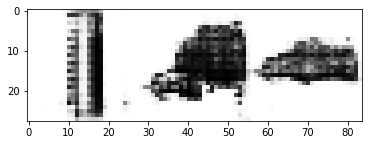

EPOCH 7/10 - d_loss 0.9335064198543783 - g_loss 1.0375707856119327


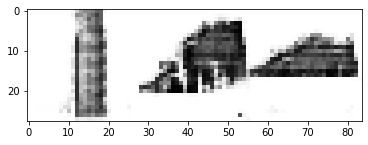

EPOCH 8/10 - d_loss 0.9299523275035776 - g_loss 1.054922029026535


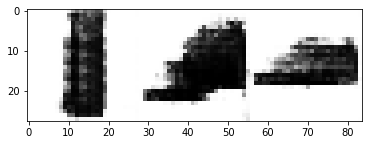

EPOCH 9/10 - d_loss 0.9183371212563786 - g_loss 1.0569993397955708


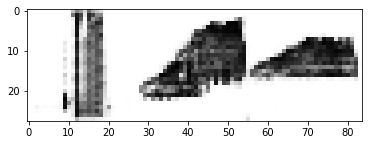

EPOCH 10/10 - d_loss 0.9403802501494439 - g_loss 1.048593860508791


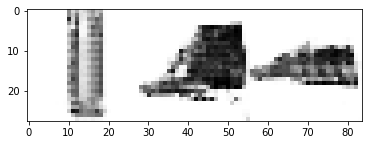

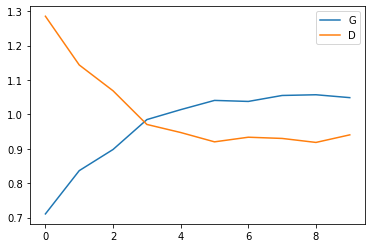

In [109]:
preshapedGenerator = PreshapedGenerator()
simpleDiscriminator = SimpleDiscriminator()
preshapedGenerator.cuda(), simpleDiscriminator.cuda()

def gen_preshaped_condition(batch_size):
    return condition[:batch_size]

train(preshapedGenerator, simpleDiscriminator, gen_preshaped_condition, epochs=10)

## Intuition n2: 
While the model with the FC layer at the top does a better job of creating "realistic" outputs, the conditioning is basically inconsequential. The results are very similar to just using noise, maybe a little worse.

And as expected, conditioning the model without a FC layer seems to be forcing the output to give similar results as the conditioning, and luckily improving the disastrous results of using only noise

EPOCH 1/10 - d_loss 1.1291084921182075 - g_loss 0.7162242427563611


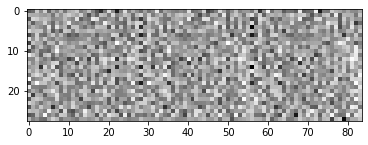

EPOCH 2/10 - d_loss 0.7645353744787445 - g_loss 0.9232353974125782


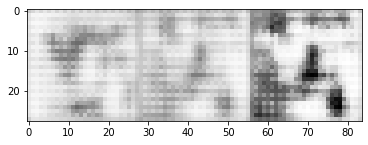

EPOCH 3/10 - d_loss 1.0903133582204647 - g_loss 0.8727131903425723


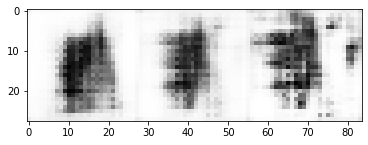

EPOCH 4/10 - d_loss 1.1937927270748998 - g_loss 0.8141628276945942


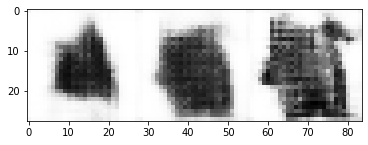

EPOCH 5/10 - d_loss 1.1804935444138471 - g_loss 0.8256550933887713


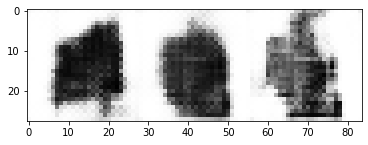

EPOCH 6/10 - d_loss 1.1465592468216996 - g_loss 0.8481596203755205


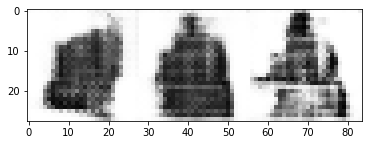

EPOCH 7/10 - d_loss 1.1042747611938502 - g_loss 0.8804066700976031


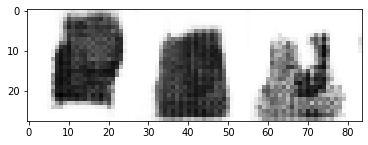

EPOCH 8/10 - d_loss 1.1076588453387386 - g_loss 0.8809634182753082


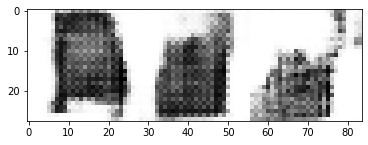

EPOCH 9/10 - d_loss 1.0738925815009879 - g_loss 0.9095408980017775


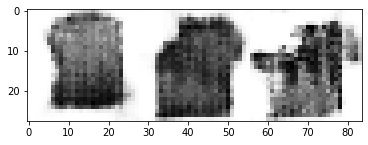

EPOCH 10/10 - d_loss 1.1575812674534607 - g_loss 0.8522190529781611


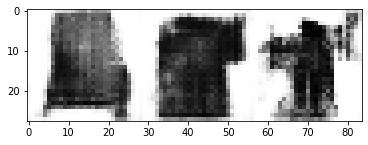

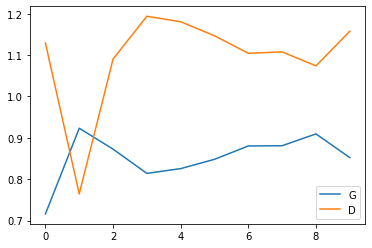

In [113]:
simpleGenerator = SimpleGenerator()
simpleDiscriminator = SimpleDiscriminator()
simpleGenerator.cuda(), simpleDiscriminator.cuda()

def gen_simple_block(batch_size):
    return torch.ones(batch_size, 7*7) * torch.randn(batch_size, 1)

train(simpleGenerator, simpleDiscriminator, gen_simple_block, epochs=10)

EPOCH 1/10 - d_loss 1.246586627670442 - g_loss 0.7393419888736328


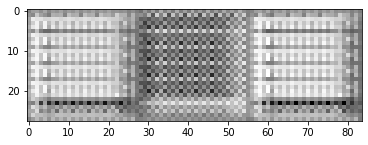

EPOCH 2/10 - d_loss 1.1354182221487894 - g_loss 0.8439007424977801


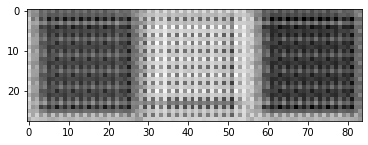

EPOCH 3/10 - d_loss 1.016968100436969 - g_loss 0.9415721628965849


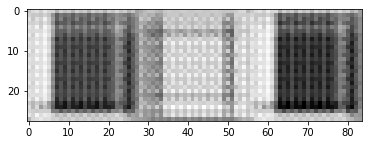

EPOCH 4/10 - d_loss 0.8975229265212001 - g_loss 1.0564830664759757


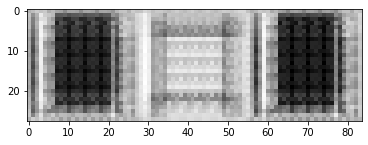

EPOCH 5/10 - d_loss 0.8305827377320366 - g_loss 1.120145311551307


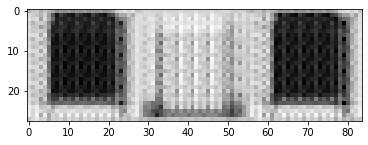

EPOCH 6/10 - d_loss 0.703229324840534 - g_loss 1.2901505510181757


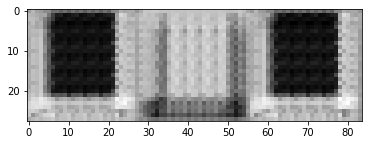

EPOCH 7/10 - d_loss 0.5779303091484853 - g_loss 1.4654162171552967


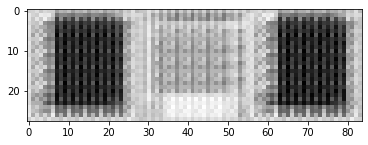

EPOCH 8/10 - d_loss 0.4886012354702838 - g_loss 1.6225235417707626


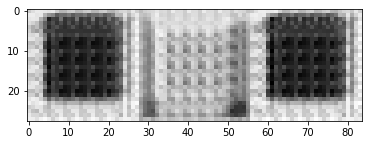

EPOCH 9/10 - d_loss 0.44754491609805147 - g_loss 1.7102733015505753


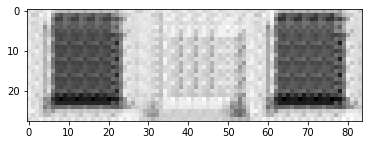

EPOCH 10/10 - d_loss 0.4097285915666552 - g_loss 1.7846320890414404


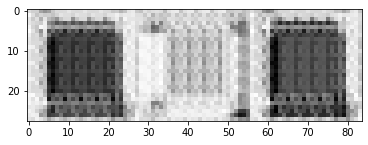

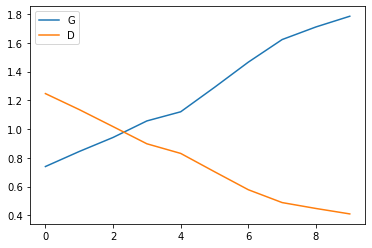

In [114]:
preshapedGenerator = PreshapedGenerator()
simpleDiscriminator = SimpleDiscriminator()
preshapedGenerator.cuda(), simpleDiscriminator.cuda()

def gen_preshaped_block(batch_size):
    return torch.ones(batch_size, 1, 7, 7) * torch.randn(batch_size, 1, 1, 1)

train(preshapedGenerator, simpleDiscriminator, gen_preshaped_block, epochs=10)

## Intuition n3: 
Yeah, what you see above... By adding the fully connected layer at the top the model is able to generate stuff even if the input is a matrix filled with the same value. If the fully connected layer is not there, the model is just blind.